# Installing prophet

In [1]:
# pip install prophet

In [1]:
# Importing libraries
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from prophet import Prophet
from tqdm import tqdm
import pandas as pd
import numpy as np
import logging

logging.getLogger('prophet').setLevel(logging.WARNING) 

## Importing train and test data
congestion = pd.read_csv('/Users/gabrielmedeiros/Desktop/Data_Science_Competitions/Comp1/train.csv')
test_data = pd.read_csv('/Users/gabrielmedeiros/Desktop/Data_Science_Competitions/Comp1/test.csv')




## Here I add the columns as strings to create the new column
congestion['location_id'] = pd.DataFrame(
                 'x' + congestion.x.astype(str) +\
                 'y' + congestion.y.astype(str) + \
                 congestion.direction.astype(str))

## Here I subset the data set into a train data for predicitons
train_prophet = congestion[['location_id', 'time' ,'congestion']]

## Here I rename the columns to match prophet's requirements (ds for dates, and y for value to be predicted)
train_prophet.columns = ['location_id','ds','y']

           
    
## Here I add the columns as strings to create the new column
test_data['location_id'] = pd.DataFrame(
                 'x' + congestion.x.astype(str) +\
                 'y' + congestion.y.astype(str) + \
                 congestion.direction.astype(str))

## Here I subset the data set into a train data for predicitons
test_prophet = test_data[['location_id', 'time']]

## Here I rename the columns to match prophet's requirements (ds for dates, and y for value to be predicted)
test_prophet.columns = ['location_id','ds']




## This data set retrieves an n number of days, in order, based on a single id match
## By doing so, I am able to retrieve a fixed number of days to be predicted for each combination
## Prophet requires the creation o an empty data frame so we can allocate the results.

## The train dataset has days of which we already have the congestion data, so we can evaluate the predictions
future_train = pd.DataFrame(train_prophet['ds'][train_prophet['location_id'] == 'x2y3NE'].reset_index(drop = True))

## The test dataset contains days of whych we do not have congestion data, which are the days to be submited
future_test = pd.DataFrame(test_prophet['ds'][test_prophet['location_id'] == 'x2y3NE'].reset_index(drop = True))



## When using prophet, we need the train and test data sets in one data set
## Hence, I concatenated both data frames I just created 

future = pd.concat([future_train, future_test])

Importing plotly failed. Interactive plots will not work.


,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


## Cross-Validation

In [ ]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics







param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = -pd.DataFrame()  # Store the RMSEs for each params here




## Here I create a group by for each location id, so we can have predictions based on each individual location
locations = train_prophet.groupby('location_id')





for params in tqdm(all_params):

    ## Here I loop through the groups
    for g in locations.groups:

        ## Here I specify the group to be used (g would be here 'x0y0EB' as an example)
        group_train = locations.get_group(g)

        ## Here we define a new prophet model so we can refresh it and use a model for each group
        ## Prophet will not allow one Prophet() model to be ran multiple times, that is why a new one
        ## is called for each loop
        m = Prophet(**params).fit(group_train)  # Fit model with given params
        df_cv = cross_validation(m, initial = '150 days',horizon = '30 days',parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        
        
        results = pd.concat([results, pd.DataFrame([df_p['rmse'].values[0],params])], ignore_index=True)

In [ ]:
params_df = pd.DataFrame(results)
params_df.columns = ['rmse','parameters']
params_df['parameters'] = params_df['parameters'].astype('str')


params_df.groupby('parameters')['rmse'].mean().sort_values()

In [36]:
## This avoids prophet from printing warning messages, but still allows tqdm to show us a progress bar
logging.getLogger('prophet').setLevel(logging.WARNING) 

## Creating empty data frame to store results
results = pd.DataFrame()


## Here I create a group by for each location id, so we can have predictions based on each individual location
locations = train_prophet.groupby('location_id')

## Here I loop through the groups
for g in tqdm(locations.groups):
    
    ## Here I specify the group to be used (g would be here 'x0y0EB' as an example)
    group_train = locations.get_group(g)
    
    ## Here we define a new prophet model so we can refresh it and use a model for each group
    ## Prophet will not allow one Prophet() model to be ran multiple times, that is why a new one
    ## is called for each loop
    prophet_md = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 0.01)
    
    ## Here, the group data is fittet into the model
    prophet_fit = prophet_md.fit(group_train)
    
    ## Here, prophet predicts congestion based on the dates specified on the 'future' data set
    forecast = prophet_fit.predict(future)
    
    ## This creates a new column in our data frame and appends the group name being used for that specific loop
    forecast['location_id'] = g
    
    ## Here we store the results in a single data frame
    results = pd.concat([results, forecast], ignore_index=True)



100%|██████████| 65/65 [04:50<00:00,  4.46s/it]


## Performance Evaluation

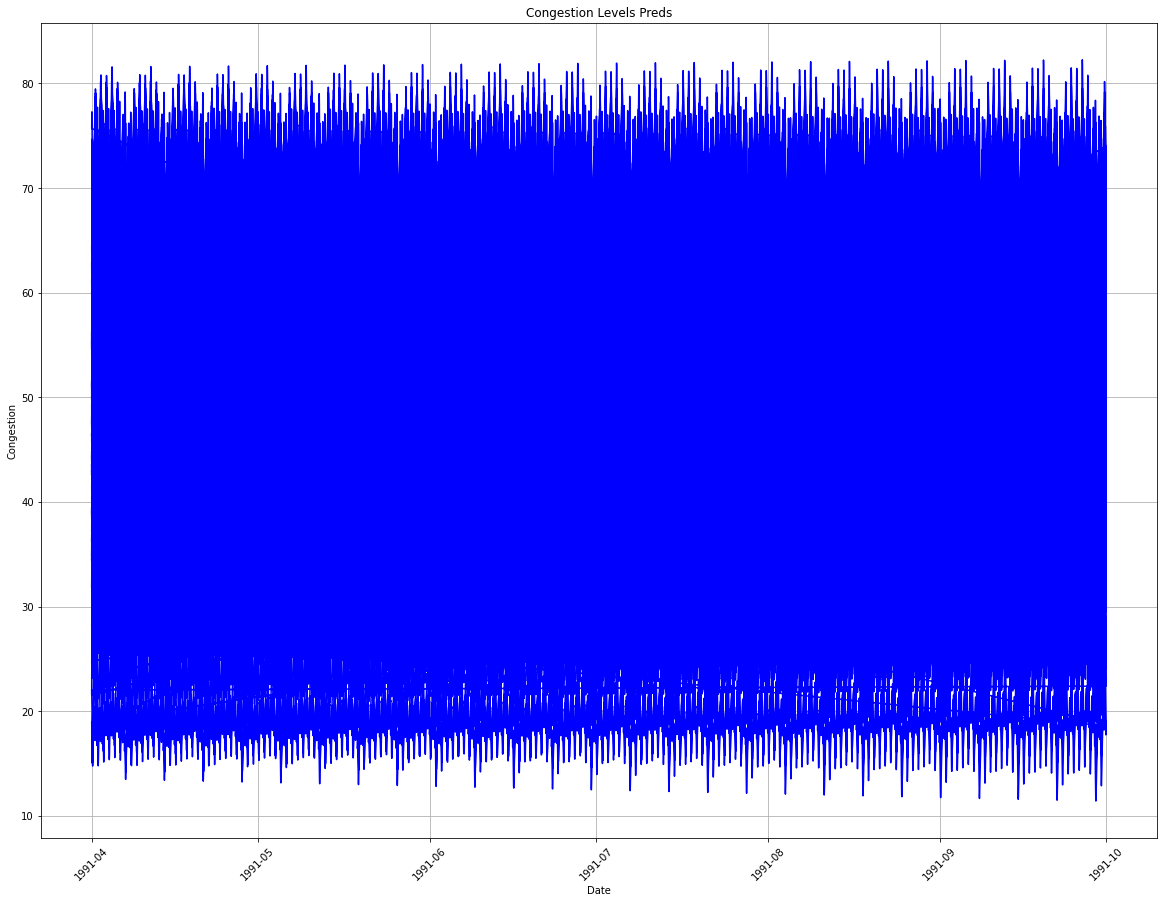

In [37]:
## Here, I ploted both train and test data

plt.figure(figsize = (20,15))
plt.plot(results.ds, results.yhat, color = 'blue')
# plt.plot(results.ds, results.yhat_upper, color = 'red')
# plt.plot(results.ds, results.yhat_lower, color = 'red')
plt.title('Congestion Levels Preds')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.xticks(rotation = 45)
plt.grid()
plt.show()

In [38]:
## Changing time format for visualizations
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])

<ipython-input-38-0750e55048b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])


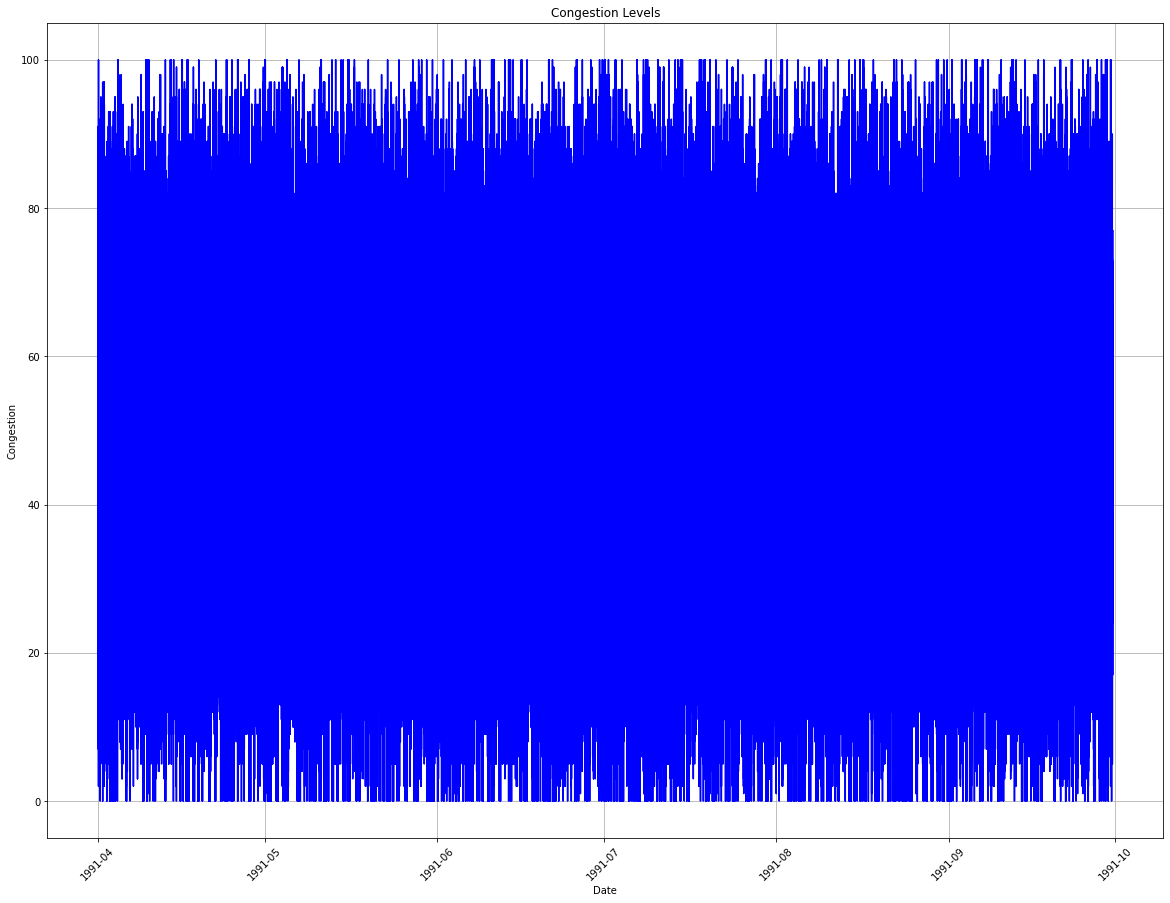

In [39]:
## This plot has the acutal data 
plt.figure(figsize = (20,15))
plt.plot(train_prophet.ds, train_prophet.y, color = 'blue')
plt.title('Congestion Levels')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.xticks(rotation = 45)
plt.grid()
plt.show()

In [40]:
## Ensuring that data is in right format 
results['ds'] = pd.to_datetime(results['ds'])

In [41]:
## Here, I copy the formatting of the results data frame
## Since I went through groups and following a chronological time it was necessary to 
## copy the same formatting to ensure that the id and times matched

train_to_evaluate = train_prophet.sort_values(by=['location_id','ds'])
train_to_evaluate.head(10)

,location_id,ds,y
0,x0y0EB,1991-04-01 00:00:00,70
65,x0y0EB,1991-04-01 00:20:00,70
130,x0y0EB,1991-04-01 00:40:00,70
195,x0y0EB,1991-04-01 01:00:00,70
260,x0y0EB,1991-04-01 01:20:00,70
325,x0y0EB,1991-04-01 01:40:00,70
390,x0y0EB,1991-04-01 02:00:00,70
455,x0y0EB,1991-04-01 02:20:00,70
520,x0y0EB,1991-04-01 02:40:00,70
585,x0y0EB,1991-04-01 03:00:00,70


In [43]:
## Here I split the results data frame to match the training data set,
## meaning that the dates on the results will only cover untill the last time available in the training data frame
results_to_evaluate = results.loc[results['ds'].isin(train_prophet.ds)]
results_to_evaluate[['location_id','ds','yhat']].head(10)

,location_id,ds,yhat
0,x0y0EB,1991-04-01 00:00:00,36.288137
1,x0y0EB,1991-04-01 00:20:00,36.774245
2,x0y0EB,1991-04-01 00:40:00,37.669029
3,x0y0EB,1991-04-01 01:00:00,38.913666
4,x0y0EB,1991-04-01 01:20:00,40.415341
5,x0y0EB,1991-04-01 01:40:00,42.056274
6,x0y0EB,1991-04-01 02:00:00,43.705543
7,x0y0EB,1991-04-01 02:20:00,45.232378
8,x0y0EB,1991-04-01 02:40:00,46.519481
9,x0y0EB,1991-04-01 03:00:00,47.474881


In [44]:
## Yhat is the value predicted, and y is the value from the training data frame
## Mean absolute error is calculated using a scikit learn library
mean_absolute_error(train_to_evaluate.y, results_to_evaluate.yhat)

6.755473595960791

In [45]:
test_data['time'] = pd.to_datetime(test_data['time'])

In [46]:
results_to_append = results.loc[results['ds'].isin(test_prophet.ds)]

In [48]:
## Example of submission
submission_data = test_data.merge(results_to_append, 
                                  how = 'left',
                                  left_on = ['time','location_id'], 
                                  right_on = ['ds','location_id'])

submission_data = submission_data[['row_id','yhat']]
submission_data.columns = ['row_id','congestion']
submission_data.head()

,row_id,congestion
0,848835,49.017353
1,848836,36.198147
2,848837,46.205000
3,848838,24.266467
4,848839,70.569648
